<a href="https://colab.research.google.com/github/wehs7661/deep_learning_projects/blob/master/covid_regression/LR2DNN/covid_regression_daily_cases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Building regression models for predicting COVID-19 daily new cases**

In this notebook, we will try to build several different regression models for predicting COVID-19 daily new cases, from a simple linear regression model, to a deep neural network. Notably, this notebook serves as the demonstration of the models explained in [this article](https://weitsehsu.com/post/covid_regression/), whose figures were all generated by this notebook. 

## Section 0. Import packages

In [1]:
# Timer
import time

In [2]:
# Google colab
from google.colab import files

In [3]:
# For data preprocess
import csv
import os
import numpy as np
import pandas as pd

In [4]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [5]:
# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.pyplot import rc
    
# Some plotting settings
rc('font', **{
   'family': 'sans-serif',
   'sans-serif': ['DejaVu Sans'],
   'size': 10
})
# Set the font used for MathJax - more on this later
rc('mathtext', **{'default': 'regular'})
plt.rc('font', family='serif')

In [6]:
seed = 1
def set_rand_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

## Section 1. Understand our dataset

Below we first download the dataset in our case: a timeseries of COVID-19 daily new cases in the United States from January 23, 2020 to July 31, 2022. This dataset wass extracted from [Our World in Data](https://ourworldindata.org/explorers/coronavirus-data-explorer?zoomToSelection=true&facet=none&hideControls=true&Metric=Confirmed+cases&Interval=New+per+day&Relative+to+Population=false&Color+by+test+positivity=false&country=~USA) and reformatted for our use.

In [7]:
# Note that this requires the installation of gdown
!gdown --id 1JSYHKqzuDTwhdtfC4dLyptJpj480sxPi --output covid_data.csv

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1JSYHKqzuDTwhdtfC4dLyptJpj480sxPi
To: /content/covid_data.csv
100% 30.3k/30.3k [00:00<00:00, 31.8MB/s]


Below we first read in the data using `pandas`.

In [8]:
df = pd.read_csv('covid_data.csv'); df

,location,date,index,new_cases
0,United States,1/23/20,0,0
1,United States,1/24/20,1,1
2,United States,1/25/20,2,0
3,United States,1/26/20,3,3
4,United States,1/27/20,4,0
...,...,...,...,...
916,United States,7/27/22,916,239176
917,United States,7/28/22,917,147362
918,United States,7/29/22,918,180053
919,United States,7/30/22,919,8888


Then, we can also visualize the time series using `matplotlib`. To get Figure 1 in the article linked above, one could just change the color to white in the first line of the second cell below, and uncomment the last line. 

In [9]:
def change_color(ax):
    # For better presentation in the webpage
    ax.tick_params(color=color, labelcolor=color)
    for spine in ax.spines.values():
        spine.set_edgecolor(color)

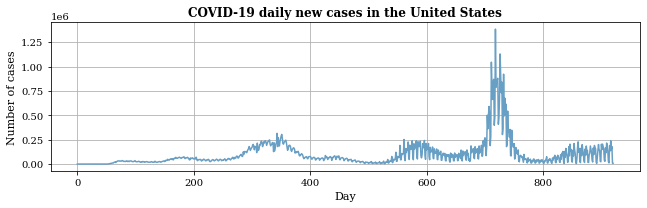

In [10]:
color = 'black'
fig = plt.figure(figsize=(9, 3))
ax = fig.add_subplot(111)
plt.plot(df['index'], df['new_cases'], color='#689fc4')
plt.xlabel('Day', color=color, fontsize=11)
plt.ylabel('Number of cases', color=color, fontsize=11)
plt.title('COVID-19 daily new cases in the United States', color=color, fontweight='bold')
plt.grid()

change_color(ax)
    
plt.tight_layout()
plt.savefig('covid_data.png', dpi=600, transparent=True)
# files.download('covid_data.png')

## Section 2. Single linear regression model

### Section 2-1. Prepare datasets

As mentioned in the article, we only consider parts of the time series:
- Training set: Days 2 to 799 (index 1 to 798)
- Testing set: Days 800 to 921 (index 799 to 920)

Let's have a quick look at our these two parts of time series before building a model:

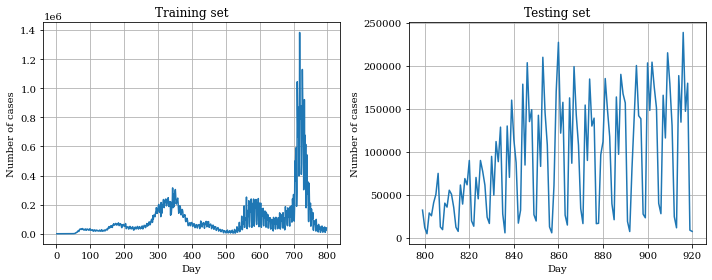

In [11]:
color = 'black'
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(121)
plt.plot(df['index'][1:798], df['new_cases'][1:798])
plt.xlabel('Day')
plt.ylabel('Number of cases')
plt.title('Training set')
plt.grid()

ax = fig.add_subplot(122)
plt.plot(df['index'][799:], df['new_cases'][799:])
plt.xlabel('Day')
plt.ylabel('Number of cases')
plt.title('Testing set')
plt.grid()
    
plt.tight_layout()
# plt.savefig('covid_data.png', dpi=600, transparent=True)

And here we define our first linear regression model as $y=b+wx_1$, where $y$ is the number of cases on Day $n$, and $x_1$ is the number of cases on Day $n-1$. Notably, each data set is $k$ by 2, with $k$ being the number of samples in the dataset (and the 2 columns include $x_1$ and $y$).

To make the preparation of datasets in later cases more convenient, we write the class `COVID19Dataset`. Note that for a model of $m$ features, we consider the new cases 1 day before, 2 days before, ..., up to $m$ days before. When preparing the dataset, we also standardize the data.

In [12]:
class COVID19Dataset(Dataset):
    def __init__(self, df, n_feats, mode, tr_idx=(1, 798), tt_idx=(799, 920)):
        self.mode = mode
        whole_data = np.array([list(df['new_cases'][:-n_feats]), list(df['new_cases'][n_feats:])]).transpose()
        
        if mode == 'test':
            data = np.array([df['new_cases'][tt_idx[0]-n : tt_idx[1]-n] for n in np.arange(n_feats, -1, -1)]).transpose()
            x = data[:, list(range(n_feats))]   # features
            y = data[:, -1]  # target
            self.x = torch.FloatTensor(x)
            self.y = torch.FloatTensor(y)
           
        else:
            # splitting training data into train & dev sets (we take 20% of the data as the validation set)
            data = np.array([df['new_cases'][tr_idx[0]-n : tr_idx[1]-n] for n in np.arange(n_feats, -1, -1)]).transpose()
            x = data[:, list(range(n_feats))]   # features
            y = data[:, -1]  # target
            
            if mode == 'train':
                idx = [i for i in range(len(x)) if i % 5 != 0]
            elif mode == 'dev':
                idx = [i for i in range(len(x)) if i % 5 == 0]
            
            self.x = torch.FloatTensor(x[idx])
            self.y = torch.FloatTensor(y[idx])
        
        self.y_mean = self.y.mean()
        self.y_std = self.y.std()
        
        # Standardize features
        self.x =(self.x - self.x.mean()) / self.x.std()
        self.y =(self.y - self.y.mean()) / self.y.std()
        
        self.dim = self.x.shape[1]
        
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return len(self.x)

### Section 2-2. Build and train the model

First of all, we define the linear regression model below.

In [13]:
class Linear_Regression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(Linear_Regression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize)
        self.criterion = torch.nn.L1Loss()  # mean absolute error
    
    def forward(self, x):
        out = self.linear(x).squeeze(1)  # `squeeze` makes the tensor from n by 1 to n (same as y)
        return out
    
    def calc_loss(self, pred, target):
        return self.criterion(pred, target)

Then, we define the following function for training the model.

In [14]:
def dev(dv_set, model):
    model.eval()                  # set model to evaluation mode
    total_loss = 0
    for x, y in dv_set:
        with torch.no_grad():     # disable gradient calculation
            pred = model(x)
            loss = model.calc_loss(pred, y)
        total_loss += loss.detach().item() * len(x)
    avg_loss = total_loss / len(dv_set.dataset)
    
    return avg_loss

In [15]:
def train(tr_set, dv_set, model, config):
    """config: A dictionary of parameters like n_epochs, lr, ..."""
    n_epochs = config['n_epochs']
    
    # Set up optimizer
    optimizer = getattr(torch.optim, config['optimizer'])(model.parameters(), config['lr'])
    
    min_loss = 1000      # just set to a large number. This will be updated later
    loss_list = {'train': [], 'dev': []}
    epoch = 0
    early_stop_cnt = 0
    while epoch < n_epochs:
        model.train()                                 # set the model to training mode
        for x, y in tr_set:
            optimizer.zero_grad()                     # clear graident buffers as we don't cumulate gradients 
            x, y = x.to('cpu'), y.to('cpu')
            pred = model(x)
            loss = model.calc_loss(pred, y)
            loss.backward()                           # compute graidents w.r.t the parameters (backpropagation)
            optimizer.step()                          # update parameters
            # loss_list['train'].append(loss.item())  # if we append here, we will have loss for every batch
        loss_list['train'].append(loss.item())        # Here we will have loss for each epoch
             
        # After each epoch, test the model on the validation (development) set
        dev_loss = dev(dv_set, model)
        if dev_loss < min_loss:
            # Save the model if your model improved
            min_loss = dev_loss
            # print(f'Saving model (epoch = {epoch + 1}, loss = {min_loss:.4f})')
            # torch.save(model.state_dict(), config['save_path'])
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1
        
        epoch += 1
        loss_list['dev'].append(dev_loss)
        if early_stop_cnt > config['early_stop']:
            # Stop training if your model stops improving for "config['early_stop']" epochs.
            break
            
    print(f'Finished training after {epoch} epochs')
    return loss_list

Now, let's load in the data, set up the parameters and start training!

In [16]:
def prep_dataloader(df, n_feats, mode, batch_size, tr_idx=(1, 798), tt_idx=(799, 920)):
    dataset = COVID19Dataset(df, n_feats, mode, tr_idx=tr_idx, tt_idx=tt_idx)
    dataloader = DataLoader(dataset, batch_size, shuffle=(mode=='train'))
    
    return dataloader

In [17]:
config = {
    'n_epochs': 5000,
    'lr': 0.001,
    'optimizer': 'SGD',
    'batch_size': 128,
    'early_stop': 1000, 
}

In [18]:
set_rand_seed(seed)
tr_set = prep_dataloader(df, 1, 'train', config['batch_size'])
dv_set = prep_dataloader(df, 1, 'dev', config['batch_size'])
tt_set = prep_dataloader(df, 1, 'test', config['batch_size'])

In [19]:
model = Linear_Regression(1, 1)
loss_list = train(tr_set, dv_set, model, config)

Finished training after 1330 epochs


### Section 2-3. Assess the model

#### 1. Training/validation loss as a function of time

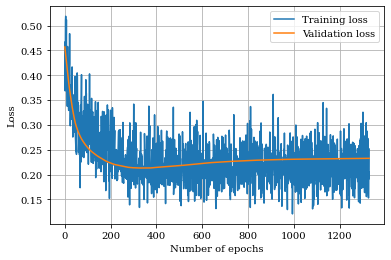

In [20]:
plt.figure()
plt.plot(loss_list['train'], label='Training loss')
plt.plot(loss_list['dev'], label='Validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()

#### 2. Comparison between the predicted and true time series

Below we compare the predictions made by the model and the true values. Note that here we convert the standardized data back to the original scale.

In [21]:
# Z score
pred_tr_z = model(tr_set.dataset.x) 
pred_dev_z = model(dv_set.dataset.x)
pred_tt_z = model(tt_set.dataset.x)

label_tr_z = tr_set.dataset.y  
label_dev_z = dv_set.dataset.y
label_tt_z = tt_set.dataset.y

# Original scale
pred_tr = pred_tr_z * tr_set.dataset.y_std + tr_set.dataset.y_mean
pred_dev = pred_dev_z * dv_set.dataset.y_std + dv_set.dataset.y_mean
pred_tt = pred_tt_z * tt_set.dataset.y_std + tt_set.dataset.y_mean

label_tr = label_tr_z * tr_set.dataset.y_std + tr_set.dataset.y_mean
label_dev = label_dev_z * dv_set.dataset.y_std + dv_set.dataset.y_mean
label_tt = label_tt_z * tt_set.dataset.y_std + tt_set.dataset.y_mean

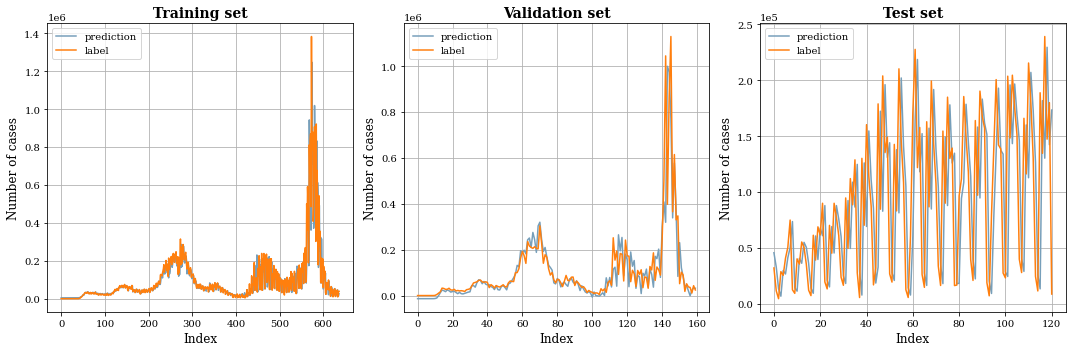

In [22]:
preds = [pred_tr, pred_dev, pred_tt]
labels = [label_tr, label_dev, label_tt]
titles = ['Training set', 'Validation set', 'Test set']

color = 'black'

fig = plt.figure(figsize=(15, 5))
for i in range(len(preds)):
    ax = fig.add_subplot(1, 3, i+1)
    plt.plot(preds[i].detach().numpy(), label='prediction', color='#779fba')
    plt.plot(labels[i].detach().numpy(), label='label', color='#ff7f0e')
    plt.ticklabel_format(style="sci", axis="y", scilimits=(0, 0))

    plt.xlabel('Index', color=color, fontsize=12)
    plt.ylabel('Number of cases', color=color, fontsize=12)
    plt.title(titles[i], color=color, fontweight='bold', fontsize=14)
    plt.legend()
    plt.grid()

    change_color(ax)

plt.tight_layout()
plt.savefig('predictions.png', dpi=600, transparent=True)
# files.download('predictions.png')

#### 3. Average loss

Below we calculate the average training loss, validation loss, and test loss in the original scale.

In [23]:
print(f'Training loss: {model.calc_loss(pred_tr, label_tr).detach().item():.0f}')
print(f'Validation loss: {model.calc_loss(pred_dev, label_dev).detach().item():.0f}')
print(f'Test loss: {model.calc_loss(pred_tt, label_tt).detach().item():.0f}')

Training loss: 30723
Validation loss: 36915
Test loss: 55202


Notably, the plots above show that the predicted time series are lagged by 1 data point (1 day) by the true time series. This is because we were making predictions based on the data history. (Check [this discussion](https://www.quora.com/What-do-lag-and-lead-mean-in-a-prediction-problem-in-machine-learning) for more.) If we shift our predictions by 1 data point, it will almost overlap with the true values, as shown below.

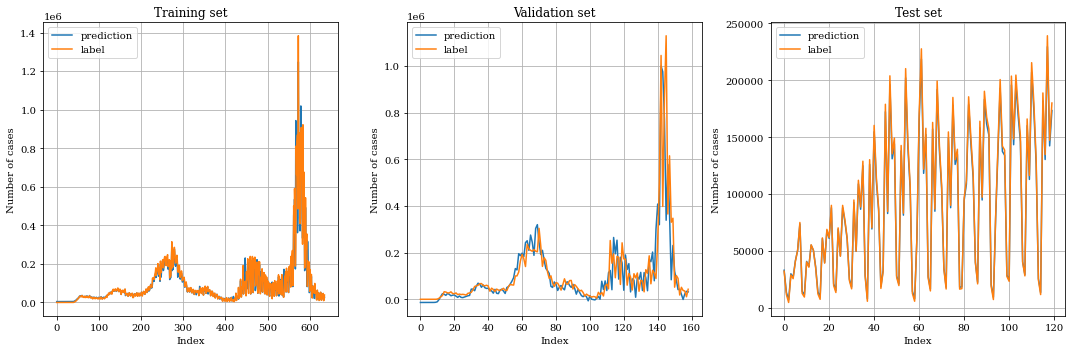

In [24]:
preds = [pred_tr, pred_dev, pred_tt]
labels = [label_tr, label_dev, label_tt]
titles = ['Training set', 'Validation set', 'Test set']

plt.figure(figsize=(15, 5))
for i in range(len(preds)):
    plt.subplot(1, 3, i + 1)
    plt.plot(preds[i].detach().numpy()[1:], label='prediction')
    plt.plot(labels[i].detach().numpy()[:-1], label='label')

    plt.xlabel('Index')
    plt.ylabel('Number of cases')
    plt.title(titles[i])
    plt.legend()
    plt.grid()

plt.tight_layout()

And if we calculate the average loss based on the shifted predictions, the loss would be very low.

In [25]:
print(f'Training loss: {model.calc_loss(pred_tr[1:], label_tr[:-1]).detach().item():.0f}')
print(f'Validation loss: {model.calc_loss(pred_dev[1:], label_dev[:-1]).detach().item():.0f}')
print(f'Test loss: {model.calc_loss(pred_tt[1:], label_tt[:-1]).detach().item():.0f}')

Training loss: 13319
Validation loss: 44876
Test loss: 3164


Notably, validation loss increases after the predicted time series is shifted by 1 day. This is because that adjacent points in the time series in the validation set do not correspond to adjacent dates, while this is the case for the the training and test sets.

#### 4. Correlation plot

Below we plot the correlation plots between our predictions and the true values. Ideally, the cluster of data should be around the diagonal line of $y=x$.

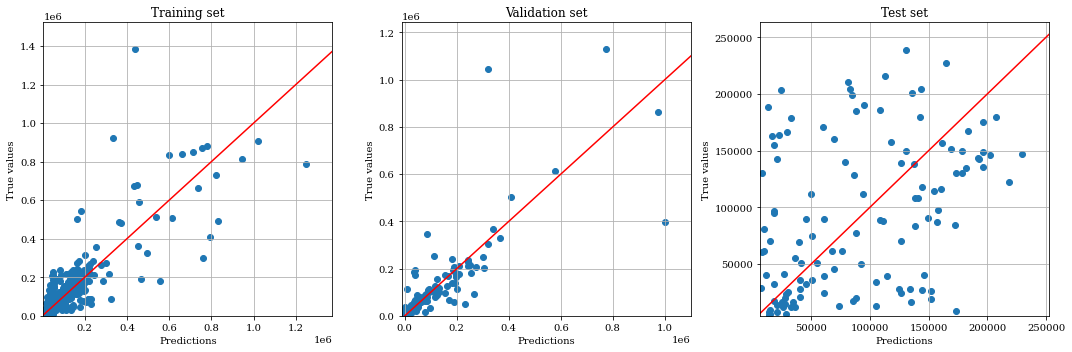

In [26]:
datasets = [tr_set, dv_set, tt_set]
plt.figure(figsize=(15, 5))
for i in range(len(datasets)):
    plt.subplot(1, 3, i + 1)
    plt.scatter(preds[i].detach().numpy(), labels[i].detach().numpy())
    plt.plot([-200000, 5000000], [-200000, 5000000], color='red')
    plt.xlabel('Predictions')
    plt.ylabel('True values')
    plt.xlim([min(preds[i].detach().numpy()) * 0.9, max(preds[i].detach().numpy()) * 1.1])
    plt.ylim([min(labels[i].detach().numpy()) * 0.9, max(labels[i].detach().numpy()) * 1.1])
    plt.title(titles[i])
    plt.grid()

plt.tight_layout()

#### 5. Regression line

Here let's check the slope and intercept of the regression line.

In [27]:
print(list(model.parameters()))
w = list(model.parameters())[0]
b = list(model.parameters())[1]

[Parameter containing:
tensor([[0.9451]], requires_grad=True), Parameter containing:
tensor([-0.0287], requires_grad=True)]


As shown above, the linear regression model is as follows: $$\left(\frac{y-\bar{y}}{\sigma_y} \right)=0.9451\left(\frac{x-\bar{x}}{\sigma_x} \right)-0.0287$$

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


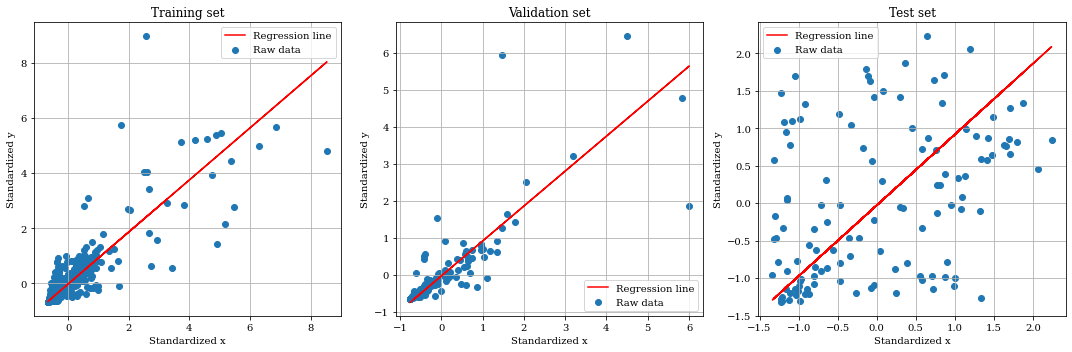

In [28]:
plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 3, i)
for i in range(len(datasets)):
    plt.subplot(1, 3, i + 1)
    plt.scatter(datasets[i].dataset.x, datasets[i].dataset.y, label='Raw data')
    plt.plot(datasets[i].dataset.x.detach().numpy(), [(i * w + b).detach().item() for i in datasets[i].dataset.x], color='red', label='Regression line')
    plt.xlabel('Standardized x')
    plt.ylabel('Standardized y')
    plt.title(titles[i])
    plt.grid()
    plt.legend()

plt.tight_layout()

Note that these plots look pretty similar to the correlation plots between the predictions and the true values. This is just because that $x$ and $y$ are roughly of the same magnitudes most of the time in the datasets.

## Section 3. Multiple linear regression (MLR) model

In this section, we will explore linear regression models with multiple features, i.e. multiple linear regression (MLR) models. Specifically, we will consider models with the following form: $$y=b + \sum_{i} w_{i}x_{i}$$ where $y$ is the number of new cases on Day $n$, and $x_i$ is the number of new cases on Day $n-i$. 

Below we will use exactly the same set of hpyerparameters and explore different numbers of features, including 7, 28, 56, and 84. To save space, we define the following function that trains and assess the models. 

In [29]:
def train_and_assess(model, n_feats, rand_seed=None):
    
    ##########################################
    #  Prepare datasets and train the model  #
    ##########################################
    t1 = time.time()
    
    config = {
        'n_epochs': 5000,
        'lr': 0.001,
        'optimizer': 'SGD',
        'batch_size': 128,
        'early_stop': 1000, 
    }
    
    if rand_seed is not None:
      set_rand_seed(rand_seed)

    tr_set = prep_dataloader(df, n_feats, 'train', config['batch_size'], tr_idx=(n_feats + 1, 798))
    dv_set = prep_dataloader(df, n_feats, 'dev', config['batch_size'], tr_idx=(n_feats + 1, 798))
    tt_set = prep_dataloader(df, n_feats, 'test', config['batch_size'], tr_idx=(n_feats + 1, 798))
    
    loss_list = train(tr_set, dv_set, model, config)
    t2 = time.time()
    print(f'Number of epochs per second {config["n_epochs"]/(t2-t1):.0f}.')
    
    ######################
    #  Assess the model  #
    ######################
    
    # 1. Loss as a function of time
    plt.figure()
    plt.plot(loss_list['train'], label='Training loss')
    plt.plot(loss_list['dev'], label='Validation loss')
    plt.xlabel('Number of epochs')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()
    
    # 2. Compare between the predicted and true time series
    
    # Z score
    pred_tr_z = model(tr_set.dataset.x) 
    pred_dev_z = model(dv_set.dataset.x)
    pred_tt_z = model(tt_set.dataset.x)

    label_tr_z = tr_set.dataset.y  
    label_dev_z = dv_set.dataset.y
    label_tt_z = tt_set.dataset.y

    # Original scale
    pred_tr = pred_tr_z * tr_set.dataset.y_std + tr_set.dataset.y_mean
    pred_dev = pred_dev_z * dv_set.dataset.y_std + dv_set.dataset.y_mean
    pred_tt = pred_tt_z * tt_set.dataset.y_std + tt_set.dataset.y_mean

    label_tr = label_tr_z * tr_set.dataset.y_std + tr_set.dataset.y_mean
    label_dev = label_dev_z * dv_set.dataset.y_std + dv_set.dataset.y_mean
    label_tt = label_tt_z * tt_set.dataset.y_std + tt_set.dataset.y_mean
    
    preds = [pred_tr, pred_dev, pred_tt]
    labels = [label_tr, label_dev, label_tt]
    titles = ['Training set', 'Validation set', 'Test set']

    plt.figure(figsize=(15, 5))
    for i in range(len(preds)):
        plt.subplot(1, 3, i + 1)
        plt.plot(preds[i].detach().numpy(), label='prediction')
        plt.plot(labels[i].detach().numpy(), label='label')

        plt.xlabel('Index')
        plt.ylabel('Number of cases')
        plt.title(titles[i])
        plt.legend()
        plt.grid()

    plt.tight_layout()
    
    # 3. Average loss
    print(f'Training loss: {model.calc_loss(pred_tr, label_tr).detach().item():.0f}')
    print(f'Validation loss: {model.calc_loss(pred_dev, label_dev).detach().item():.0f}')
    print(f'Test loss: {model.calc_loss(pred_tt, label_tt).detach().item():.0f}')
    
    # 4. Correlation plots
    datasets = [tr_set, dv_set, tt_set]
    plt.figure(figsize=(15, 5))
    for i in range(len(datasets)):
        plt.subplot(1, 3, i + 1)
        plt.scatter(preds[i].detach().numpy(), labels[i].detach().numpy())
        plt.plot([-200000, 5000000], [-200000, 5000000], color='red')
        plt.xlabel('Predictions')
        plt.ylabel('True values')
        plt.xlim([min(preds[i].detach().numpy()) * 0.9, max(preds[i].detach().numpy()) * 1.1])
        plt.ylim([min(labels[i].detach().numpy()) * 0.9, max(labels[i].detach().numpy()) * 1.1])
        plt.title(titles[i])
        plt.grid()

    plt.tight_layout()

Finished training after 5000 epochs
Number of epochs per second 186.
Training loss: 21119
Validation loss: 25759
Test loss: 32175


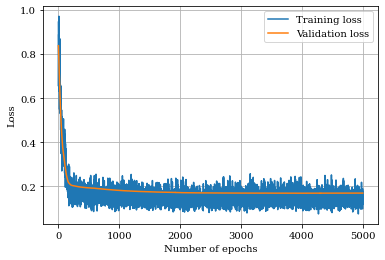

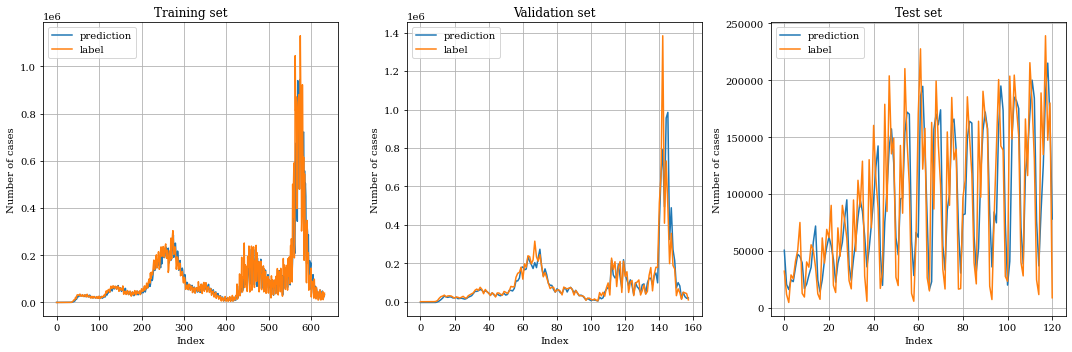

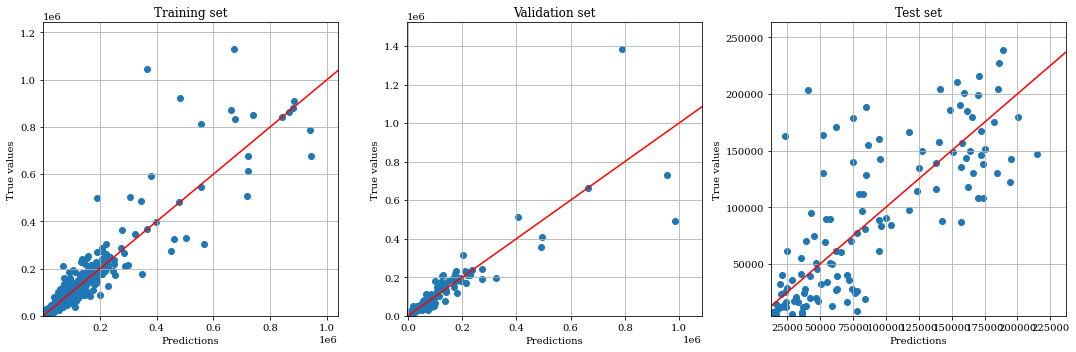

In [30]:
n_feats = 7
model = Linear_Regression(n_feats, 1) 
train_and_assess(model, n_feats, rand_seed=seed)

Finished training after 4732 epochs
Number of epochs per second 190.
Training loss: 16112
Validation loss: 17163
Test loss: 25213


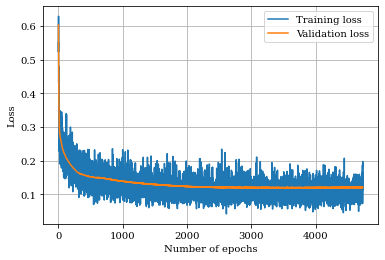

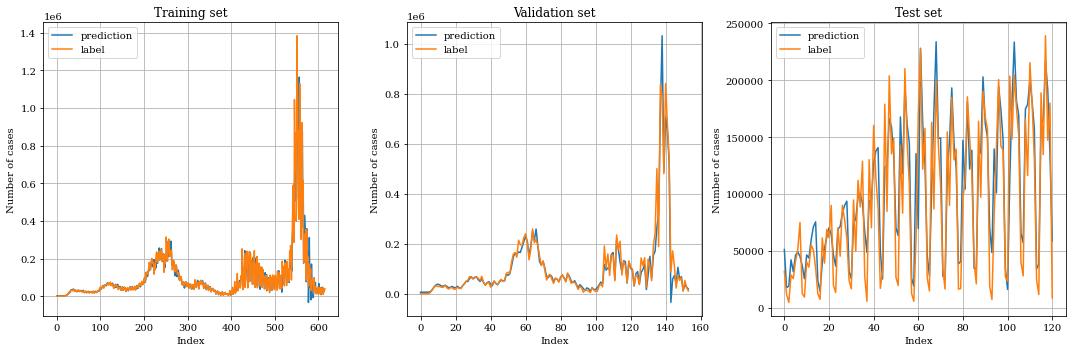

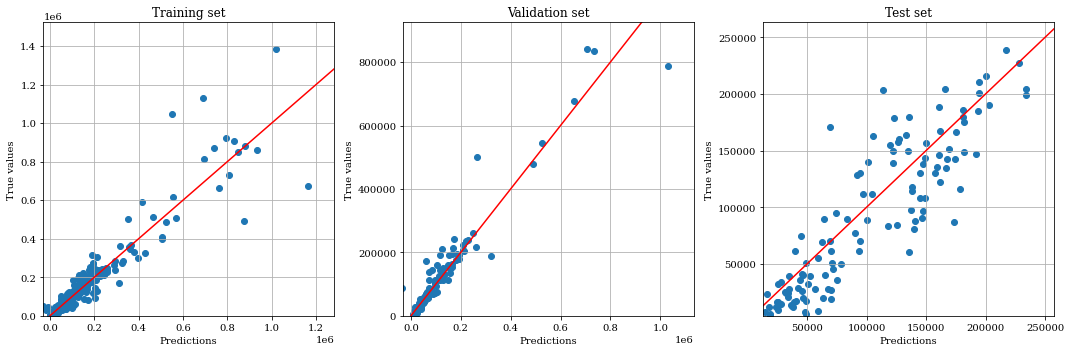

In [31]:
n_feats = 28
model = Linear_Regression(n_feats, 1) 
train_and_assess(model, n_feats, rand_seed=seed)

Finished training after 3971 epochs
Number of epochs per second 241.
Training loss: 15847
Validation loss: 19728
Test loss: 28755


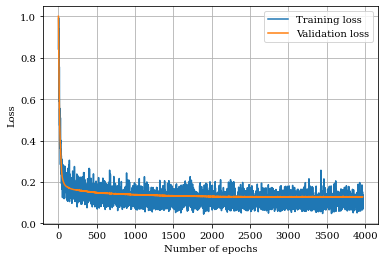

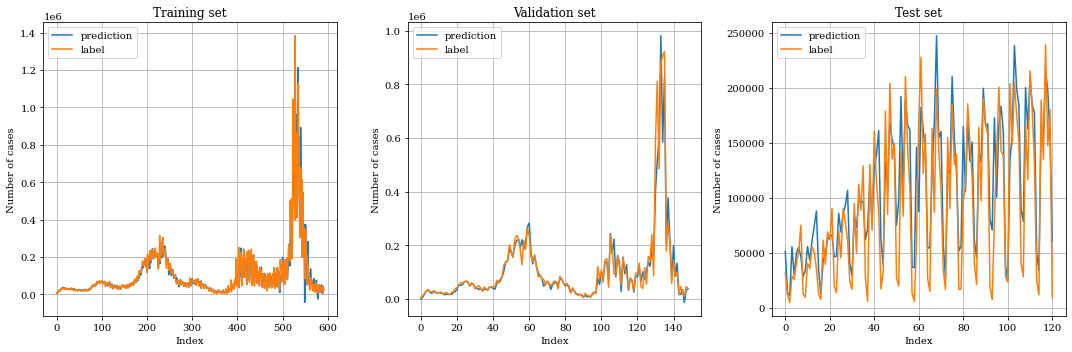

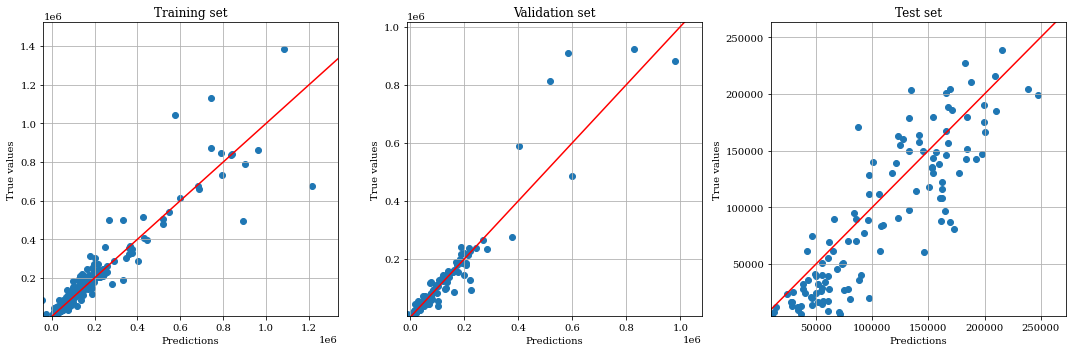

In [32]:
n_feats = 56
model = Linear_Regression(n_feats, 1) 
train_and_assess(model, n_feats, rand_seed=seed)

Finished training after 1985 epochs
Number of epochs per second 418.
Training loss: 16388
Validation loss: 24825
Test loss: 38102


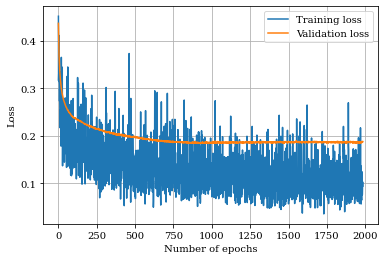

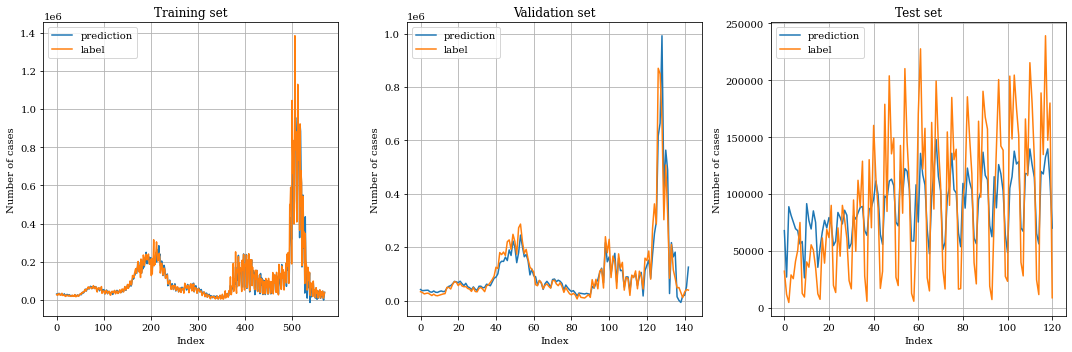

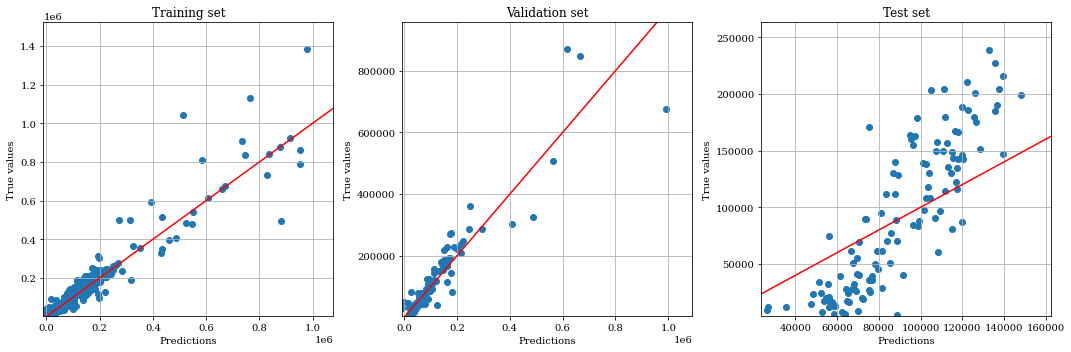

In [33]:
n_feats = 84
model = Linear_Regression(n_feats, 1) 
train_and_assess(model, n_feats, rand_seed=seed)

Below we tabulate the results for the models above.


| # of features   | 1     | 7     | 28    | 56    | 84    |
|-----------------|-------|-------|-------|-------|-------|
| Training loss   | 30723 | 21119 | 16112 | 15847 | 16388 |
| Validation loss | 36915 | 25759 | 17163 | 19728 | 24825 |
| Test loss       | 55202 | 32175 | 25213 | 28755 | 38102 |

Or, we can plot the results as below.

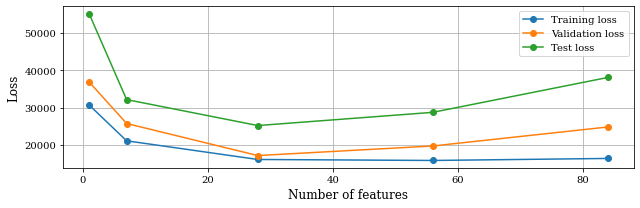

In [34]:
color = 'black'

n_feats = [1, 7, 28, 56, 84]
tr_loss = [30723, 21119, 16112, 15847, 16388]
dev_loss = [36915, 25759, 17163, 19728, 24825]
tt_loss = [55202, 32175, 25213, 28755, 38102]

fig = plt.figure(figsize=(9, 3))
ax = fig.add_subplot(111)
plt.plot(n_feats, tr_loss, label='Training loss', marker='o')
plt.plot(n_feats, dev_loss, label='Validation loss', marker='o')
plt.plot(n_feats, tt_loss, label='Test loss', marker='o')
plt.xlabel('Number of features', color=color, fontsize=12)
plt.ylabel('Loss', color=color, fontsize=12)
plt.grid()
plt.legend()
plt.tight_layout()

change_color(ax)
    
plt.savefig('MLR_loss.png', dpi=600, transparent=True)
# files.download('MLR_loss.png')

As shown above, the validation loss and test loss are both lowest at `n_feats=28`. When the number of features increased to 56, the model starts to show signs of overfitting (i.e. low training loss but high test loss). In the model where 84 features were considered, the test loss was even higher (more overfitting). Among all the models examined above, the model of 28 features shows the best performance. 

## Section 4. Regression models using ReLU functions

One obvious disadvantage of linear regression models is that they assume either a strictly increasing/decreasing relationship between the output $y$ and each of the input features $x_i$. As an example, in our first trained model $\left(\frac{y-\bar{y}}{\sigma_y} \right)=0.9451\left(\frac{x_1-\bar{x_1}}{\sigma_x} \right)-0.0287$, it was assumed that the Z-score of $x$ should always be smaller than the Z-score of $y$, which might not always be true. We call this deviation derived from the design of the model the model bias. Although in the MLR models explored above, a larger number of features can indeed weaken the model bias, we should consider other possibilities if we want to account for the fluctuations in the time series with more flexibility.

So how do we account for the fluctuations in the time series? To approach this, we can first consider a simpler example as shown below, where we want to model $f(x)$.  

In [35]:
def sigmoid(x, b, c, w):
    return c / (1 + np.exp(-(b + w * x)))

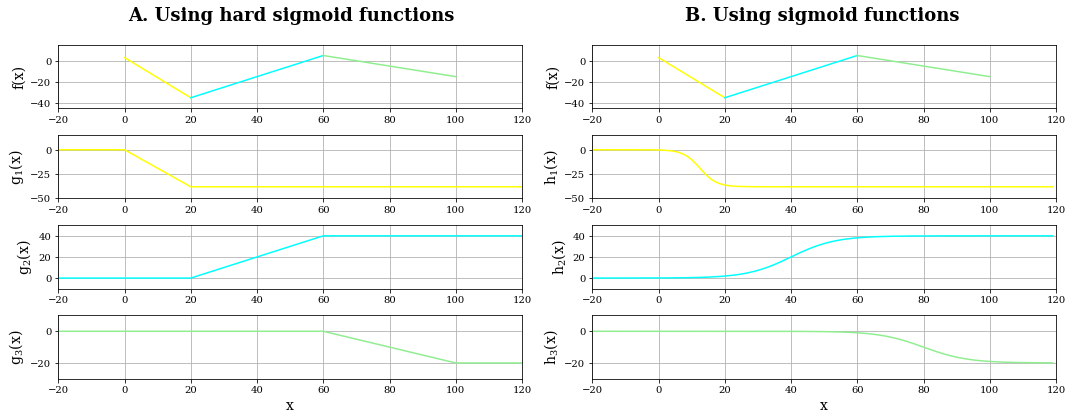

In [36]:
color = 'black'

fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(421)
plt.text(0.15, 1.60, 'A. Using hard sigmoid functions', transform=plt.gca().transAxes, fontweight='bold', va='top', ha='left', fontsize=18, color=color)
plt.plot([0, 20], [3, -35], color='yellow')
plt.plot([20, 60], [-35, 5], color='cyan')
plt.plot([60, 100], [5, -15], color='lightgreen')
# plt.xlabel('x', color=color, fontsize=11)
plt.ylabel('f(x)', color=color, fontsize=14)
plt.xlim([-20, 120])
plt.ylim([-45, 15])
plt.grid()
change_color(ax)

ax = fig.add_subplot(423)
plt.plot([-20, 0, 20, 120], [0, 0, -38, -38], color='yellow')
# plt.xlabel('x', color=color, fontsize=11)
plt.ylabel(r'$g_1(x)$', color=color, fontsize=14)
plt.xlim([-20, 120])
plt.ylim([-50, 15])
plt.grid()
change_color(ax)

ax = fig.add_subplot(425)
plt.plot([-20, 20, 60, 120], [0, 0, 40, 40], color='cyan')
# plt.xlabel('x', color=color, fontsize=11)
plt.ylabel(r'$g_2(x)$', color=color, fontsize=14)
plt.xlim([-20, 120])
plt.ylim([-10, 50])
plt.grid()
change_color(ax)

ax = fig.add_subplot(427)
plt.plot([-20, 60, 100, 120], [0, 0, -20, -20], color='lightgreen')
plt.xlabel('x', color=color, fontsize=14)
plt.ylabel(r'$g_3(x)$', color=color, fontsize=14)
plt.xlim([-20, 120])
plt.ylim([-30, 10])
plt.grid()
change_color(ax)

ax = fig.add_subplot(422)
plt.text(0.2, 1.60, 'B. Using sigmoid functions', transform=plt.gca().transAxes, fontweight='bold', va='top', ha='left', fontsize=18, color=color)
plt.plot([0, 20], [3, -35], color='yellow')
plt.plot([20, 60], [-35, 5], color='cyan')
plt.plot([60, 100], [5, -15], color='lightgreen')
# plt.xlabel('x', color=color, fontsize=11)
plt.ylabel('f(x)', color=color, fontsize=14)
plt.xlim([-20, 120])
plt.ylim([-45, 15])
plt.grid()
change_color(ax)

ax = fig.add_subplot(424)
plt.plot(np.arange(-20, 120), sigmoid(np.arange(-20, 120), b=-5, c=-38, w=0.4), color='yellow')
# plt.xlabel('x', color=color, fontsize=11)
plt.ylabel(r'$h_1(x)$', color=color, fontsize=14)
plt.xlim([-20, 120])
plt.ylim([-50, 15])
plt.grid()
change_color(ax)

ax = fig.add_subplot(426)
plt.plot(np.arange(-20, 120), sigmoid(np.arange(-20, 120), b=-6, c=40, w=0.15), color='cyan')
# plt.xlabel('x', color=color, fontsize=11)
plt.ylabel(r'$h_2(x)$', color=color, fontsize=14)
plt.xlim([-20, 120])
plt.ylim([-10, 50])
plt.grid()
change_color(ax)

ax = fig.add_subplot(428)
plt.plot(np.arange(-20, 120), sigmoid(np.arange(-20, 120), b=-12, c=-20, w=0.15), color='lightgreen')
plt.xlabel('x', color=color, fontsize=14)
plt.ylabel(r'$h_3(x)$', color=color, fontsize=14)
plt.xlim([-20, 120])
plt.ylim([-30, 10])
plt.grid()
change_color(ax)

plt.tight_layout()
plt.savefig('fluctuation_model.png', dpi=600, transparent=True)
# files.download('fluctuation_model.png')

As shown in the left panel of the figure above, the three segments of $f(x)$ are basically shifted $g_1(x)$, $g_2(x)$ and $g_3(x)$, respectively, which are piecewise linear functions (or more specifically, hard sigmoid functions). Therefore $f(x)$ can be easily modified as the sum of $g_1(x)$, $g_2(x)$ and $g_3(x)$, shifted by a constant value. If we want to model $f(x)$ with smoother functions, we could consider sigmoid functions like $h_1(x)$, $h_2(x)$ and $h_3(x)$, whose general form is $$y=\frac{c}{1 + \exp(-(b+wx))}=c\cdot \text{sigmoid}(b+wx)$$ That is, we can define the model for approximate $f(x)$ as $$y = b + \sum_{i}^{3}c_i \cdot \text{sigmoid}(b_i + w_ix)$$

Back to our original problem, if we only consider 1 feature ($x_1$, the new cases of the previous day), the model can be defined as $y=b+\sum_i^n c_i \cdot \sigma(b_i+w_ix_1)$, where $\sigma$ is the sigmoid function and $n$ is the number of sigmoid functions, another hyperparameter that we need to decide. If multiple features are considered, we can define the model as below: $$y=b+\sum_i^n c_i \cdot \sigma(b_i+\sum_j^m w_{ij} x_j)=b+{\bf c}^T \sigma({\bf b} + W {\bf x})$$ where $\bf x$, $\bf b$, and $\bf c$ are all column vectors and $W$ is a matrix and $m$ is the number of features. If you find the term ${\bf b} + W {\bf x}$ not intuitive, try considering its matrix form, e.g. the term ${\bf r} = {\bf b} + W {\bf x}$ of a model considering 3 features and using 2 sigmoid functions can be written as {{<math>}}$$ \begin{bmatrix} r_1 \\ r_2 \end{bmatrix}= \begin{bmatrix} b_1 \\ b_2 \end{bmatrix} + \begin{bmatrix} w_{11} & w_{12} & w_{13} \\ w_{21} & w_{22} & w_{23}\end{bmatrix}\begin{bmatrix} x_1 \\ x_2 \\  x_3 \end{bmatrix}$${{</math>}}

Note that we are not restricted to only using the sigmoid function! For example, we can also use rectified unit (ReLU) functions $y=c\cdot \max(0, b+wx)$. Two ReLU functions can compose of one hard sigmoid function (see the left panel below), or can model other functions with more flexibility (see the right panel below). With ReLU functions, we could define the model as $y=b+\sum_i c_i^n \max(0, b_i + \sum_{j}^m w_{ij}x_j)$.

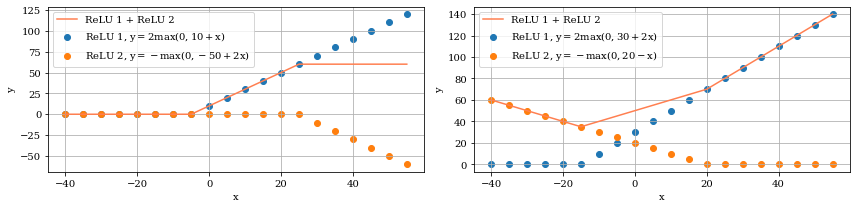

In [37]:
color='black'

fig = plt.figure(figsize=(12, 3))
x = np.arange(-40, 60, 5)
y1 = np.array([np.max([0, i]) for i in 10 + 2 * x])
y2 = -np.array([np.max([0, i]) for i in -50 + 2 * x])
y3 = np.array(y1) + np.array(y2)

ax = fig.add_subplot(121)
plt.scatter(x, y1, label=r'ReLU 1, $y=2max(0, 10+x)$')
plt.scatter(x, y2, label='ReLU 2, $y=-max(0, -50+2x)$')
plt.plot(x, y3, label='ReLU 1 + ReLU 2', color='coral')
plt.xlabel('x', color=color)
plt.ylabel('y', color=color)
change_color(ax)
plt.grid()
plt.legend()

y1 = np.array([np.max([0, i]) for i in 30 + 2 * x])
y2 = np.array([np.max([0, i]) for i in 20 -  x])
y3 = np.array(y1) + np.array(y2)

ax = fig.add_subplot(122)
plt.scatter(x, y1, label='ReLU 1, $y=2max(0, 30+2x)$')
plt.scatter(x, y2, label='ReLU 2, $y=-max(0, 20-x)$')
plt.plot(x, y3, label='ReLU 1 + ReLU 2', color='coral')
plt.xlabel('x', color=color)
plt.ylabel('y', color=color)
change_color(ax)
plt.grid()
plt.legend()

plt.tight_layout()
plt.savefig('ReLU.png', dpi=600, transparent=True)
# files.download('ReLU.png')

Here, let's consider a model of 28 features with different numbers ($n$) of ReLU functions to model the COVID-19 daily new cases. Notably, below we use `torch.nn.ReLU()` to define the model, but one could also use `torch.relu` or `torch.functional.relu`. Here are some discussions about the differences between these three:
- [PyTorch discussion](https://discuss.pytorch.org/t/what-is-the-difference-between-torch-relu-torch-nn-relu-and-torch-nn-functional-relu/91101/2)
- [An article by Joel Tok](https://www.joeltok.com/posts/2020-04-pytorch-f-relu-to-nn-relu/)

In [38]:
class ReLU_Regression(torch.nn.Module):
    def __init__(self, inputSize, outputSize, n_relu):
        super(ReLU_Regression, self).__init__()
        self.linear_1= torch.nn.Linear(inputSize, n_relu)
        self.relu = torch.nn.ReLU()
        self.linear_2 = torch.nn.Linear(n_relu, outputSize)
        self.criterion = torch.nn.L1Loss()  # mean absolute error

    def forward(self, x):
        x = self.relu(self.linear_1(x))  # max(0, b + Wx)
        x = self.linear_2(x).squeeze(1)  # `squeeze` makes the tensor from n by 1 to n (same as y)
        return x
      
    def calc_loss(self, pred, target):
        return self.criterion(pred, target)

Importantly, the class `ReLU_Regression` can also be written as below:

In [39]:
class ReLU_Regression(torch.nn.Module):
    def __init__(self, inputSize, outputSize, n_relu):
        super(ReLU_Regression, self).__init__()
        self.model = torch.nn.Sequential()
        self.model.add_module(f'linear 1', torch.nn.Linear(inputSize, n_relu))
        self.model.add_module(f'activation 1', torch.nn.ReLU())
        self.model.add_module(f'linear 2', torch.nn.Linear(n_relu, outputSize))
        self.criterion = torch.nn.L1Loss()  # mean absolute error

    def forward(self, x):
        x = self.model(x).squeeze(1)
        return x
      
    def calc_loss(self, pred, target):
        return self.criterion(pred, target)

Finished training after 5000 epochs
Number of epochs per second 162.
Training loss: 13762
Validation loss: 16514
Test loss: 23778


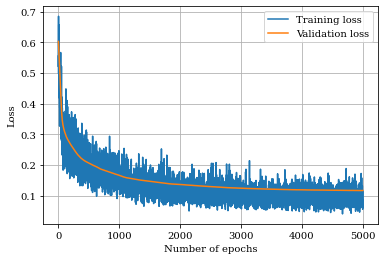

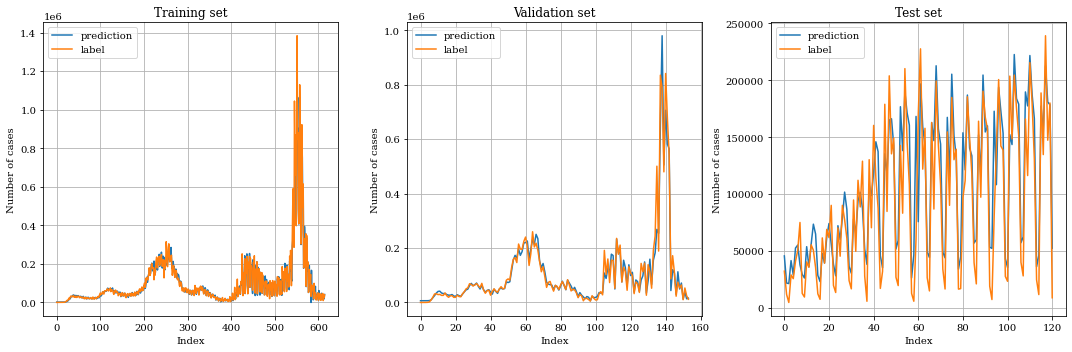

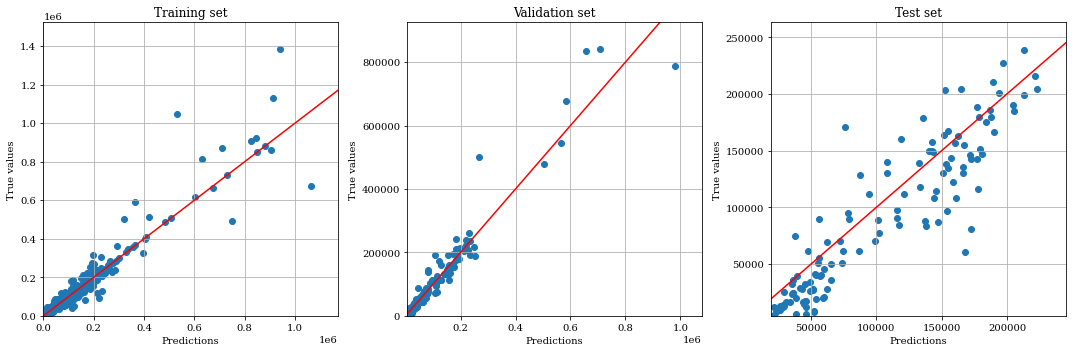

In [40]:
n_feats = 28
model = ReLU_Regression(n_feats, 1, 10)
train_and_assess(model, n_feats, rand_seed=seed)

Finished training after 5000 epochs
Number of epochs per second 150.
Training loss: 12587
Validation loss: 15498
Test loss: 22417


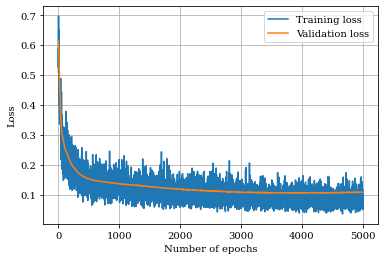

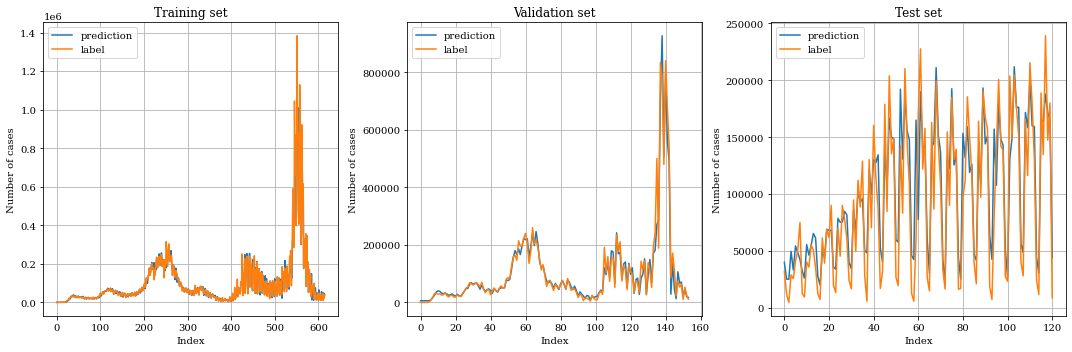

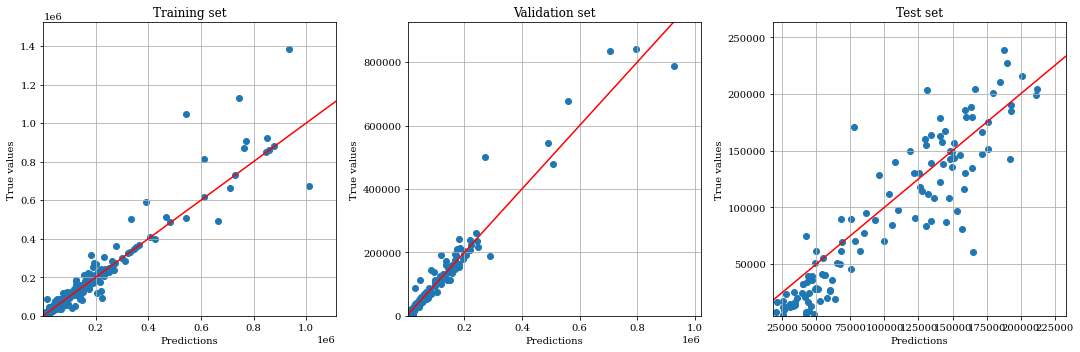

In [41]:
n_feats = 28
model = ReLU_Regression(n_feats, 1, 50) 
train_and_assess(model, n_feats, rand_seed=seed)

Finished training after 3275 epochs
Number of epochs per second 203.
Training loss: 11652
Validation loss: 15988
Test loss: 22319


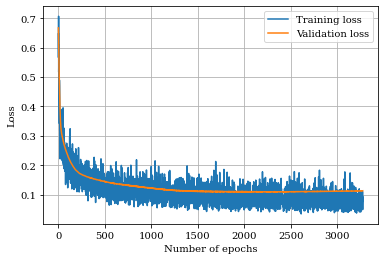

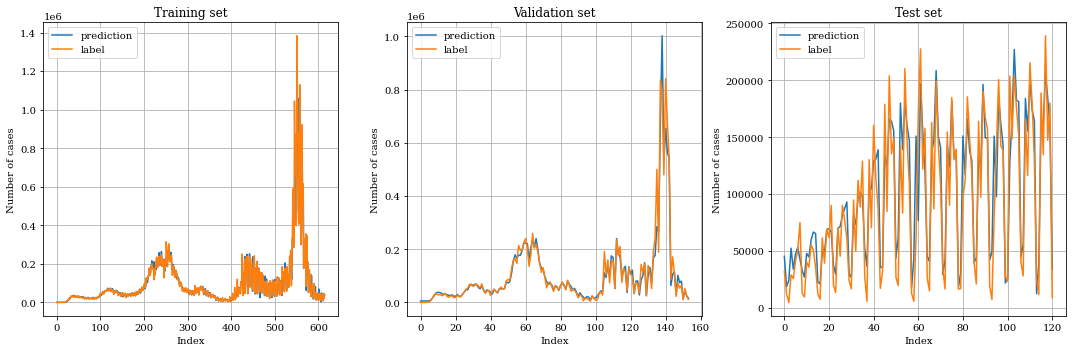

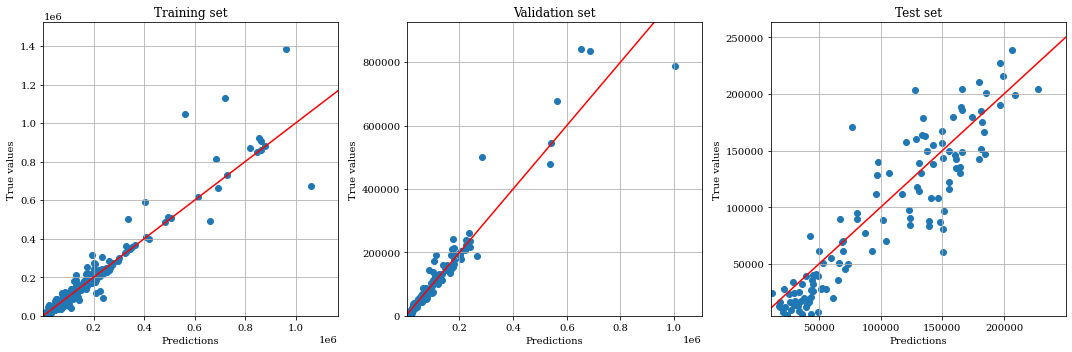

In [42]:
n_feats = 28
model = ReLU_Regression(n_feats, 1, 200) 
train_and_assess(model, n_feats, rand_seed=seed)

Finished training after 2363 epochs
Number of epochs per second 275.
Training loss: 11456
Validation loss: 16172
Test loss: 25770


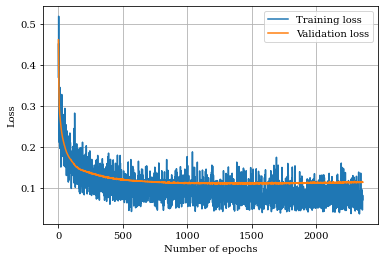

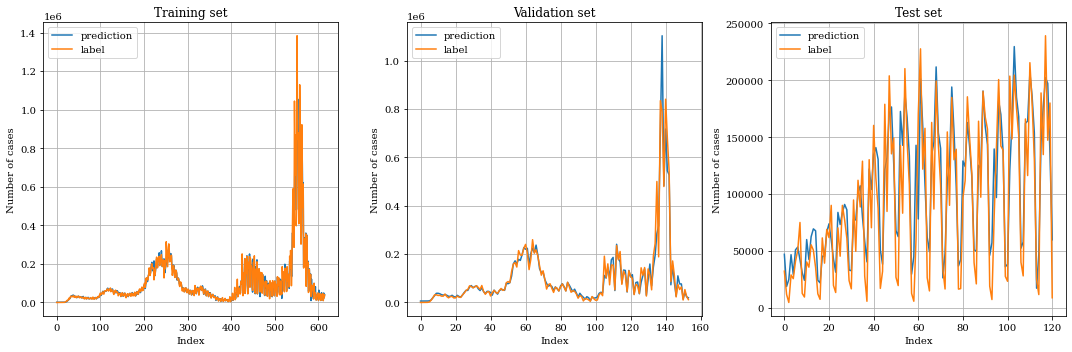

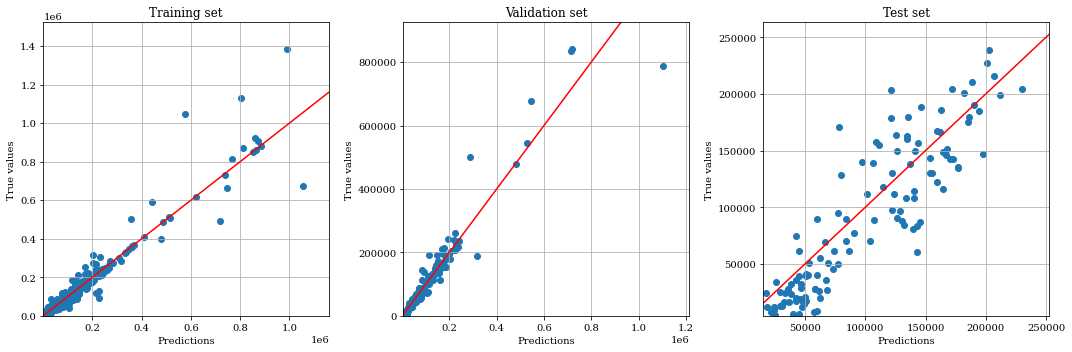

In [43]:
n_feats = 28
model = ReLU_Regression(n_feats, 1, 500) 
train_and_assess(model, n_feats, rand_seed=seed)

One could also try other kinds functions to build the model. As an example, we could use the following class to build a regression model composed of $N$ sigmoid function. Here we will not build more models to make the notebook longer though.

In [44]:
class Sigmoid_Regression(torch.nn.Module):
    def __init__(self, inputSize, outputSize, n_sigmoid):
        super(Sigmoid_Regression, self).__init__()
        self.linear_1= torch.nn.Linear(inputSize, n_sigmoid)
        self.sigmoid = torch.nn.Sigmoid()
        self.linear_2 = torch.nn.Linear(n_sigmoid, outputSize)
        self.criterion = torch.nn.L1Loss()  # mean absolute error

    def forward(self, x):
        x = self.sigmoid(self.linear_1(x))  # max(0, b + Wx)
        x = self.linear_2(x).squeeze(1)  # `squeeze` makes the tensor from n by 1 to n (same as y)
        return x
      
    def calc_loss(self, pred, target):
        return self.criterion(pred, target)

Below we tabulate the results obtained from different ReLU regression models that all adopted 28 features.

| # of features   | MLR | 10 ReLU | 50 ReLU |200 ReLU | 500 ReLU |
|-----------------|--------|---------|----------|----------|-----------|
| Training loss   | 16112  | 13762   | 12587    | 11652    | 11456     |
| Validation loss | 17163  | 16514   | 15498    | 15988    | 16172     | 
| Test loss       | 25213  | 23778   | 22417    | 22319    | 25770     | 

<Figure size 432x288 with 0 Axes>

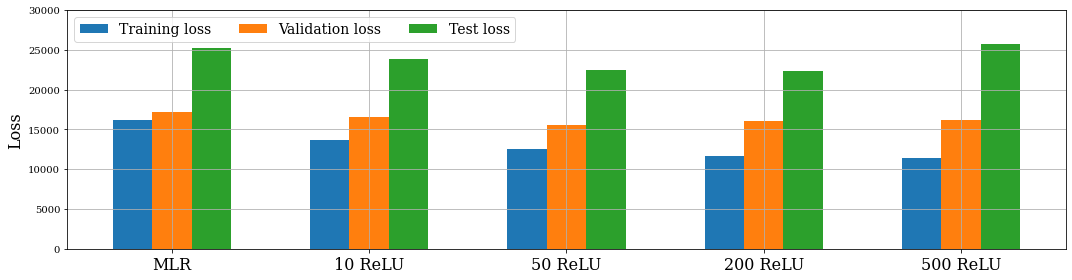

In [45]:
color = 'black'

plt.figure()
tr_loss = [16112, 13672, 12587, 11652, 11456]
dev_loss = [17163, 16514, 15498, 15988, 16172]
tt_loss = [25213, 23778, 22417, 22319, 25770]

models = ['MLR', '10 ReLU', '50 ReLU', '200 ReLU', '500 ReLU']
X_axis = np.arange(len(models)) / 2

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(111)
plt.bar(X_axis -0.1, tr_loss, 0.1, label='Training loss')
plt.bar(X_axis, dev_loss, 0.1, label='Validation loss')
plt.bar(X_axis +0.1, tt_loss, 0.1, label='Test loss')
plt.xticks(X_axis, models, color=color, fontsize=16)
plt.ylabel('Loss', color=color, fontsize=16)
plt.ylim([0, 30000])
plt.legend(loc="upper left", ncol=3, fontsize=14)
plt.grid()

change_color(ax)
plt.tight_layout()
plt.savefig('ReLU_regression.png', dpi=600, transparent=True)
# files.download('ReLU_regression.png')

As shown above, ReLU regression models generally perform better than the MLR model, with the performance roughly increasing with $n$. However, if $n$ is increased to 500, the model starts to show signs of overfitting.  

## Section 5. Deep neural networks

Below we define a class that can specify the number of layers of a neural network.

In [46]:
class ReLU_Regression(torch.nn.Module):
    def __init__(self, inputSize, outputSize, n_relu):
        super(ReLU_Regression, self).__init__()
        self.model = torch.nn.Sequential()
        self.model.add_module(f'linear 1', torch.nn.Linear(inputSize, n_relu))
        self.model.add_module(f'activation 1', torch.nn.ReLU())
        self.model.add_module(f'linear 2', torch.nn.Linear(n_relu, outputSize))
        self.criterion = torch.nn.L1Loss()  # mean absolute error

    def forward(self, x):
        x = self.model(x).squeeze(1)
        return x
      
    def calc_loss(self, pred, target):
        return self.criterion(pred, target)

In [47]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self, inputSize, outputSize, n_relu, n_hidden_layers):
        super(NeuralNetwork, self).__init__()
        self.nn = torch.nn.Sequential()
        for i in range(n_hidden_layers):
            self.nn.add_module(f'Linear {i}', torch.nn.Linear(inputSize, n_relu))
            self.nn.add_module(f'Activation {i}', torch.nn.ReLU())
            inputSize = n_relu
        self.nn.add_module('Output', torch.nn.Linear(n_relu, outputSize))
        self.criterion = torch.nn.L1Loss()  # mean absolute error

    def forward(self, x):
        x = self.nn(x).squeeze(1)
        return x
      
    def calc_loss(self, pred, target):
        return self.criterion(pred, target)

Finished training after 5000 epochs
Number of epochs per second 146.
Training loss: 12026
Validation loss: 16730
Test loss: 22270


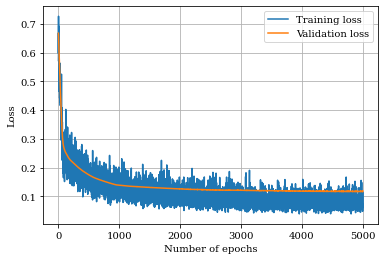

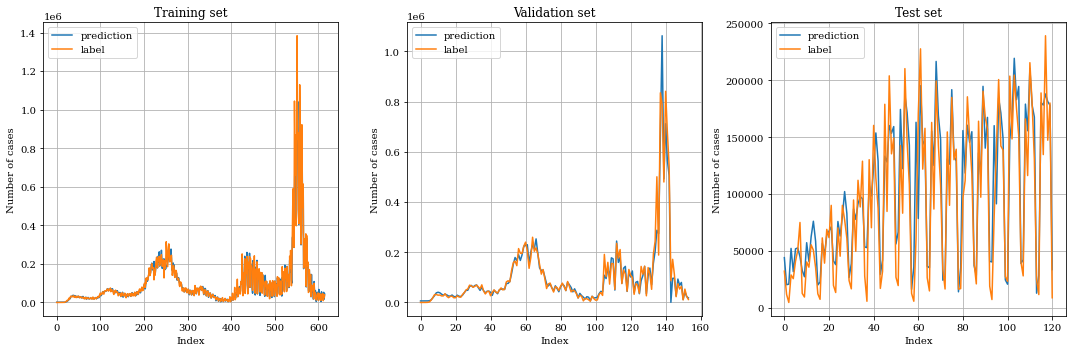

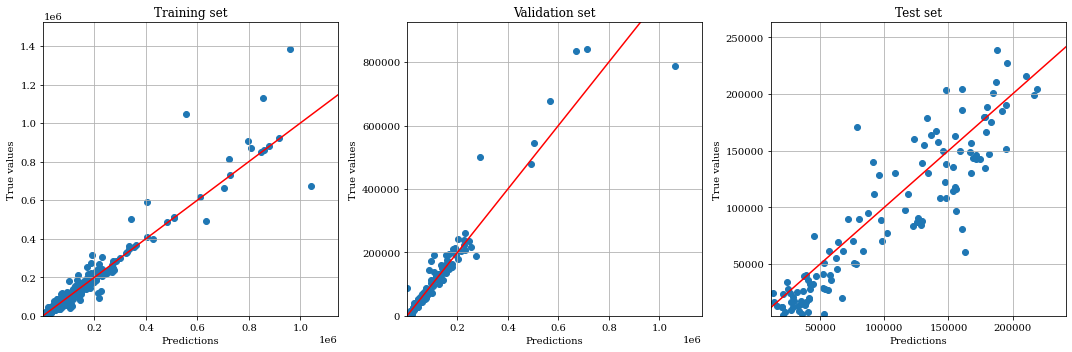

In [48]:
# 2-layer NN, which is exactly the same as the model we had in the previous section (50 ReLU)!
model = NeuralNetwork(inputSize=28, outputSize=1, n_relu=50, n_hidden_layers=1)    # 28 features   
train_and_assess(model, 28, rand_seed=seed)

Finished training after 5000 epochs
Number of epochs per second 142.
Training loss: 12718
Validation loss: 14676
Test loss: 23715


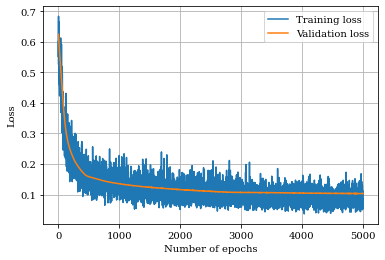

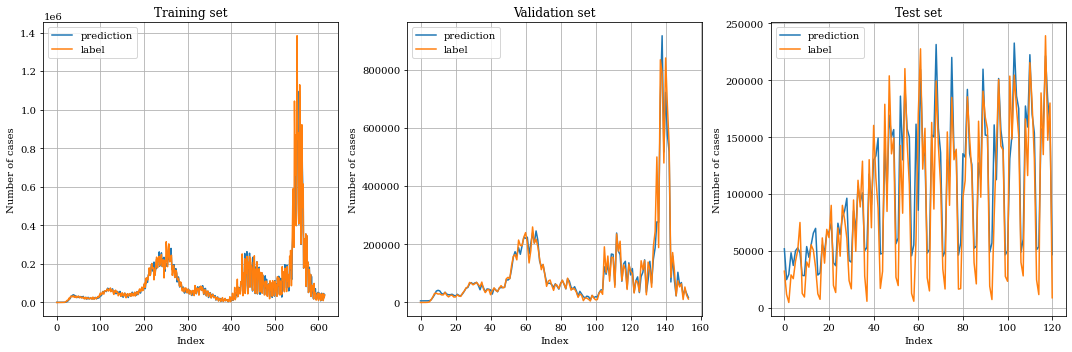

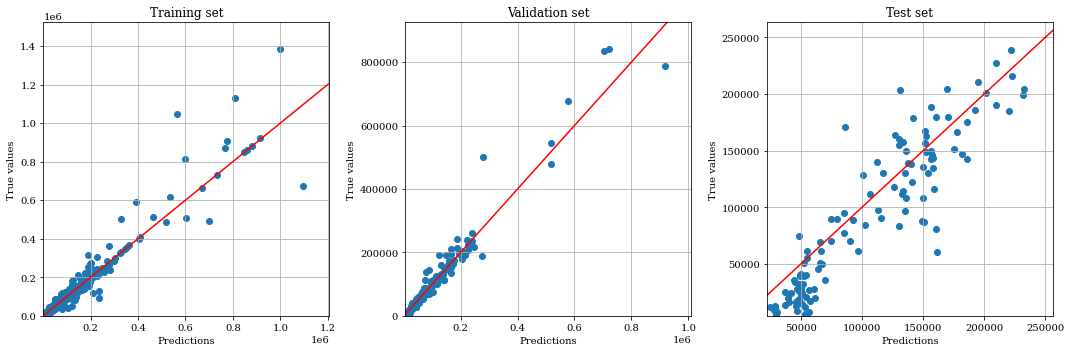

In [49]:
# 3-layer NN
model = NeuralNetwork(inputSize=28, outputSize=1, n_relu=50, n_hidden_layers=2)    # 28 features   
train_and_assess(model, 28, rand_seed=seed)

Finished training after 5000 epochs
Number of epochs per second 130.
Training loss: 13460
Validation loss: 14883
Test loss: 27217


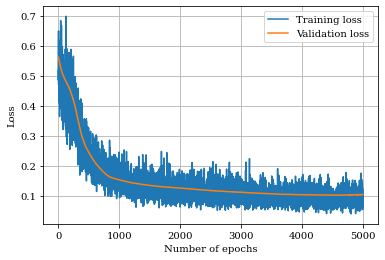

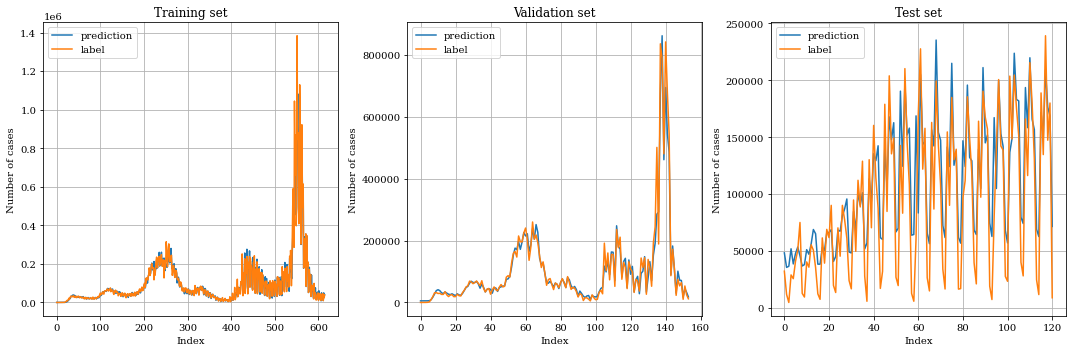

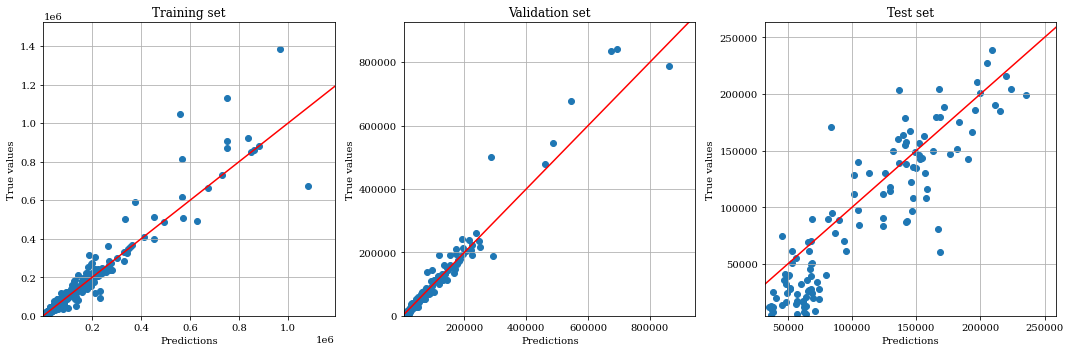

In [50]:
# 4-layer NN
model = NeuralNetwork(inputSize=28, outputSize=1, n_relu=50, n_hidden_layers=3)    # 28 features   
train_and_assess(model, 28, rand_seed=seed)

As shown above, multi-layer neural networks could hardly drive the test loss even lower and it starts to overfit very quickly (from the 4-layer neural network). In fact, there are other more complicated neural networks that are more suitable for time-series forecasting, not the simple neural networks we are trying here.